Import libraries and dataset

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
import sys

y_label = 'Renewal_Flag'
df = pd.read_csv("data/Slot Performance Data.csv")
df[['StartDate','EndDate']] = df[['StartDate','EndDate']].apply(pd.to_datetime)
df['day_diff'] = (df['EndDate'] - df['StartDate']).dt.days

Keep the same metrics in metric design notebook

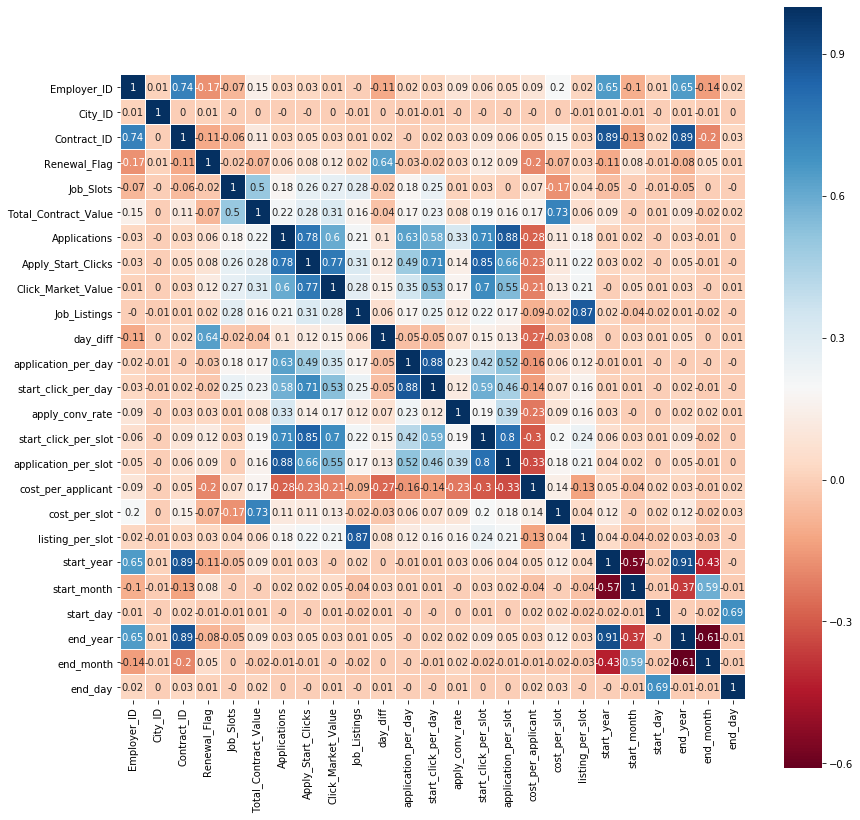

In [2]:
df_metrics = df
df_metrics['application_per_day'] = df['Applications'] / df['day_diff']
df_metrics['start_click_per_day'] = df['Apply_Start_Clicks'] / df['day_diff']
df_metrics['apply_conv_rate'] = (df['Applications'] / df['Apply_Start_Clicks']).replace(np.nan, 0)
df_metrics['start_click_per_slot'] = df['Apply_Start_Clicks'] / df['Job_Slots']
df_metrics['application_per_slot'] = df['Applications'] / df['Job_Slots']
df_metrics['cost_per_applicant'] = df['Total_Contract_Value'] / df['Applications']
df_metrics['cost_per_slot'] = df['Total_Contract_Value'] / df['Job_Slots']
df_metrics['listing_per_slot'] = df['Job_Listings'] / df['Job_Slots']

df_metrics['start_year'] = pd.DatetimeIndex(df_metrics['StartDate']).year
df_metrics['start_month'] = pd.DatetimeIndex(df_metrics['StartDate']).month
df_metrics['start_day'] = pd.DatetimeIndex(df_metrics['StartDate']).day
df_metrics['end_year'] = pd.DatetimeIndex(df_metrics['EndDate']).year
df_metrics['end_month'] = pd.DatetimeIndex(df_metrics['EndDate']).month
df_metrics['end_day'] = pd.DatetimeIndex(df_metrics['EndDate']).day

colormap = plt.cm.RdBu
f, axs = plt.subplots(1, 1, figsize=(14, 14))
#ax = plt.subplot(3, 3, idx + 1)
sns.heatmap(df_metrics.corr(method='pearson', min_periods=1).round(decimals=2), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)
#plt.xticks(rotation=30, fontsize=7)
plt.show()

Take a look in Renewal_Flag distribution

([<matplotlib.axis.XTick at 0x11fe30b20>,
 <a list of 2 Text xticklabel objects>)

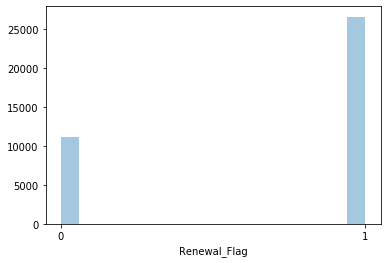

In [104]:
sns.distplot(df_metrics[y_label], kde=False)
plt.xticks([0, 1])

Train-test split

In [3]:
df_train = df_metrics.replace([np.inf, -np.inf], np.nan).dropna()
df_train.drop(['Employer_ID', 'City_ID', 'Contract_ID', 'StartDate', 'EndDate'], axis=1, inplace=True)
training_set, testing_test = train_test_split(df_train, test_size=0.2)
y_train, y_test = training_set[y_label], testing_test[y_label]
x_train, x_test = training_set.drop(y_label, axis=1), testing_test.drop(y_label, axis=1)
x_train

,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,day_diff,application_per_day,start_click_per_day,apply_conv_rate,...,application_per_slot,cost_per_applicant,cost_per_slot,listing_per_slot,start_year,start_month,start_day,end_year,end_month,end_day
23251,15,745,160,160,2736.00,0,30,5.333333,5.333333,1.000000,...,10.666667,4.656250,49.666667,0.000000,2017,8,22,2017,9,21
34465,50,2995,400,530,12353.30,5,27,14.814815,19.629630,0.754717,...,8.000000,7.487500,59.900000,0.100000,2017,2,14,2017,3,13
21356,15,995,55,80,2264.80,10,27,2.037037,2.962963,0.687500,...,3.666667,18.090909,66.333333,0.666667,2018,2,3,2018,3,2
34172,15,495,5,45,1836.70,10,29,0.172414,1.551724,0.111111,...,0.333333,99.000000,33.000000,0.666667,2017,6,23,2017,7,22
31546,15,1245,15,30,1425.00,5,30,0.500000,1.000000,0.500000,...,1.000000,83.000000,83.000000,0.333333,2018,3,6,2018,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,15,995,50,240,5771.25,0,30,1.666667,8.000000,0.208333,...,3.333333,19.900000,66.333333,0.000000,2017,8,11,2017,9,10
5637,15,1745,100,135,3082.75,0,29,3.448276,4.655172,0.740741,...,6.666667,17.450000,116.333333,0.000000,2017,9,27,2017,10,26
36367,15,1745,25,45,1824.00,0,14,1.785714,3.214286,0.555556,...,1.666667,69.800000,116.333333,0.000000,2016,11,17,2016,12,1
13252,15,745,15,20,979.80,5,27,0.555556,0.740741,0.750000,...,1.000000,49.666667,49.666667,0.333333,2016,11,12,2016,12,9


Try random forest with 500 trees on Renewal_Flag classification

In [41]:
def evaluate_performance(model):
    y_pred = model.predict(x_test)
    n_correct = sum(y_pred == y_test)
    print("Overall performance")
    print("accuracy: {}".format(float(n_correct) / len(y_pred)))
    print("recall: {}".format(recall_score(y_test, y_pred)))
    print("f1: {}".format(f1_score(y_test, y_pred)))
    print("\n Confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print("\n Label performance")
    print("classification_report: {}".format(classification_report(y_test, y_pred)))
    
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf.fit(x_train, y_train)
dump(rf_clf, 'models/rf_500_est.joblib')
evaluate_performance(rf_clf)

Overall performance
accuracy: 0.9273426889995473
recall: 0.9953416149068323
f1: 0.9523102065072054

 Confusion matrix
[[ 892  306]
 [  15 3205]]

 Label performance
classification_report:               precision    recall  f1-score   support

           0       0.98      0.74      0.85      1198
           1       0.91      1.00      0.95      3220

    accuracy                           0.93      4418
   macro avg       0.95      0.87      0.90      4418
weighted avg       0.93      0.93      0.92      4418



Retrieve feature importance by the random forest

Feature ranking:
1. feature day_diff (0.3818904309856106)
2. feature Click_Market_Value (0.076229432999335)
3. feature end_month (0.06292583324487022)
4. feature start_click_per_day (0.051354060697495485)
5. feature application_per_day (0.04838568398962558)
6. feature start_month (0.04728411213853937)
7. feature end_day (0.03353493665870857)
8. feature Apply_Start_Clicks (0.03258664877139186)
9. feature start_day (0.031880643339912695)
10. feature start_click_per_slot (0.031073093075691362)
11. feature start_year (0.030790654246788222)
12. feature cost_per_applicant (0.030614190342828883)
13. feature apply_conv_rate (0.02909638789693472)
14. feature Applications (0.021079980210205313)
15. feature application_per_slot (0.020251413832544234)
16. feature end_year (0.01901839931611303)
17. feature cost_per_slot (0.014732957969989366)
18. feature Total_Contract_Value (0.01457143561478593)
19. feature Job_Listings (0.010686365683395276)
20. feature listing_per_slot (0.010516146367890009)
21.

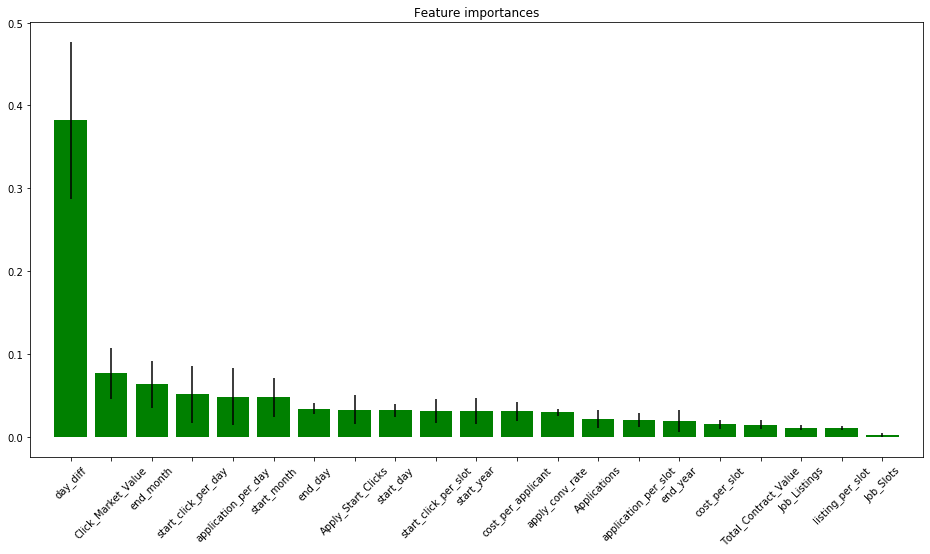

In [85]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = []

print("Feature ranking:")
for f in range(x_train.shape[1]):
    feature_name = x_train.columns[indices[f]]
    feature_names.append(feature_name)
    print("{}. feature {} ({})".format(f + 1, feature_name, importances[indices[f]]))

# Plot the feature importances of the forest
f, axs = plt.subplots(1, 1, figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), feature_names)
plt.xlim([-1, x_train.shape[1]])
plt.xticks(rotation=45)
plt.show()

Try retrieving feature importance using Gradient Boosting forest

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=200)
gb_clf.fit(x_train, y_train)
dump(gb_clf, 'models/gb_200_est.joblib')
evaluate_performance(gb_clf)

Feature ranking:
1. feature day_diff (0.6673769221745097)
2. feature end_month (0.16339359852202412)
3. feature start_year (0.05343577009669247)
4. feature Click_Market_Value (0.028231417381660257)
5. feature start_month (0.01137658303704049)
6. feature apply_conv_rate (0.011080876415994145)
7. feature start_day (0.008524498970161973)
8. feature cost_per_applicant (0.008116674253387598)
9. feature start_click_per_day (0.007502092499300801)
10. feature end_day (0.005804369677322363)
11. feature start_click_per_slot (0.005348309579428754)
12. feature Total_Contract_Value (0.004926002378911548)
13. feature application_per_day (0.004612697402966686)
14. feature Apply_Start_Clicks (0.004542988337220489)
15. feature cost_per_slot (0.003833517036788319)
16. feature application_per_slot (0.003371927447076967)
17. feature listing_per_slot (0.002945639730015439)
18. feature Applications (0.0024554588700337002)
19. feature Job_Listings (0.002294232501781915)
20. feature end_year (0.00072780884277

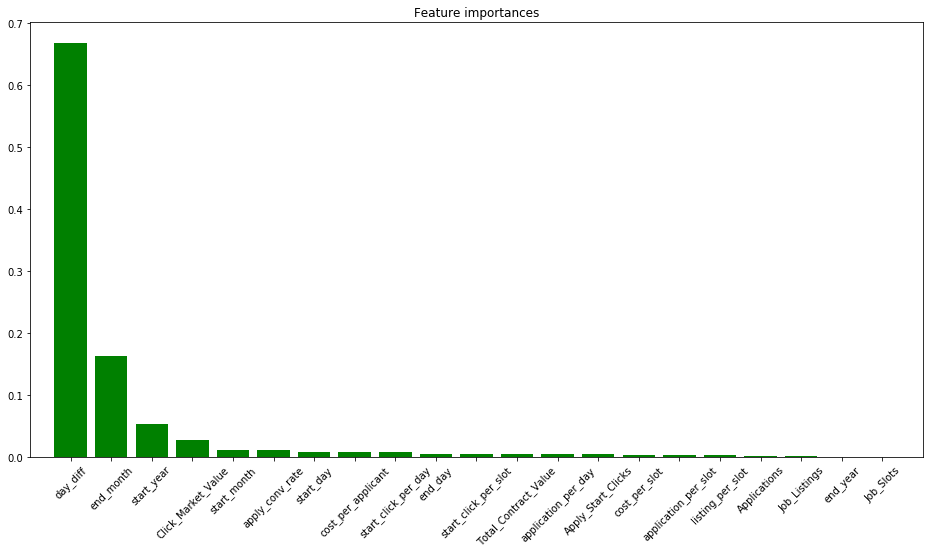

In [87]:
importances = gb_clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in gb_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = []

print("Feature ranking:")
for f in range(x_train.shape[1]):
    feature_name = x_train.columns[indices[f]]
    feature_names.append(feature_name)
    print("{}. feature {} ({})".format(f + 1, feature_name, importances[indices[f]]))

# Plot the feature importances of the forest
f, axs = plt.subplots(1, 1, figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", align="center")
plt.xticks(range(x_train.shape[1]), feature_names)
plt.xlim([-1, x_train.shape[1]])
plt.xticks(rotation=45)
plt.show()

Self implement grid search

In [35]:
def dict_product(d):
    keys = d.keys()
    for element in product(*d.values()):
        yield dict(zip(keys, element))
        
def GridSearchWithVal(model_class, param_grid, metrics='accuracy', cv=5):
    combinations = list(dict_product(param_grid))
    max_metrics = 0
    best_comb = None
    y_test_len = len(y_test)
    a=0
    print("{} combinations in total. Metric: {}".format(len(combinations), metrics))
    for idx, comb in enumerate(combinations):
        model = model_class(**comb, n_jobs=-1)
        model.fit(x_train, y_train)
        y_preds = model.predict(x_test)
        # print("y_preds:{}".format(y_preds))
        # print("y_test:{}".format(y_test.values))
        error = 0;

        #scores = cross_val_score(model, X, Y, cv=cv, scoring=metrics)
        n_correct = sum(y_preds == y_test)
        acc = n_correct / y_test_len

        if acc > max_metrics:
            max_metrics = acc
            a=n_correct
            best_comb = comb
        progress_str = "{} / {}, {},{}, best comb: {}, best score: {}".format(idx + 1, len(combinations), 
                                                                              a,y_test_len,
                                                                              best_comb, max_metrics)
        sys.stdout.write('\r' + progress_str)

    print("best params:{}".format(best_comb))
    print("max {}: {}".format(metrics, max_metrics))
    return best_comb

Grid search random forest parameter space

In [36]:
rf_param_grid = {"n_estimators" : [50, 100, 200, 500],
                  "criterion" : ["gini"],
                  "max_depth": [None],
                  "max_features": [0.1, 0.2, 0.5, 0.8, None],
                  "min_samples_split": [2, 3, 4, 5],
                  "min_samples_leaf": [1, 3],
                  "bootstrap": [True, False]
                 }
rf_best = GridSearchWithVal(RandomForestClassifier, rf_param_grid)

320 combinations in total. Metric: accuracy
320 / 320, 4109,4418, best comb: {'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}, best score: 0.9300588501584427best params:{'n_estimators': 500, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}
max accuracy: 0.9300588501584427


Performance of grid-searched best model on testing set

In [37]:
rf_best_clf = RandomForestClassifier(**rf_best)
rf_best_clf.fit(x_train, y_train)
evaluate_performance(rf_best_clf)

Overall performance
accuracy: 0.9293798098687189
recall: 0.9944099378881988
f1: 0.9535437760571769

 Confusion matrix
[[ 904  294]
 [  18 3202]]

 Label performance
classification_report:               precision    recall  f1-score   support

           0       0.98      0.75      0.85      1198
           1       0.92      0.99      0.95      3220

    accuracy                           0.93      4418
   macro avg       0.95      0.87      0.90      4418
weighted avg       0.93      0.93      0.93      4418



Some explorative analysis on Renewal_Flag. First split data

In [64]:
df_unrenew = df_metrics[df_metrics['Renewal_Flag'] == 0]
df_renew = df_metrics[df_metrics['Renewal_Flag'] == 1]

Peek cost_per_applicant distributions by Renewal_Flag

(0, 500)

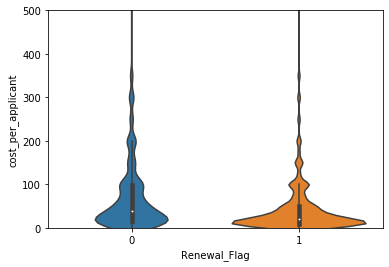

In [65]:
#sns.distplot(df_renew['Applications'].replace([np.inf, -np.inf], np.nan).dropna(), kde=False, label='renew')
#sns.distplot(df_unrenew['Applications'].replace([np.inf, -np.inf], np.nan).dropna(), kde=False, label='non-renew')
#plt.legend()

# plt.title("day_diff distribution for non-renewal samples")
sns.violinplot(x='Renewal_Flag', y='cost_per_applicant',  data=df_metrics.replace([np.inf, -np.inf], np.nan).dropna())
plt.ylim(0, 500)

Peek listing_per_slot distributions by Renewal_Flag

(0, 2)

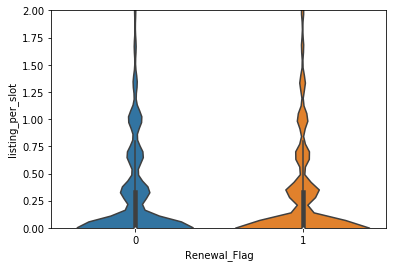

In [80]:
sns.violinplot(x='Renewal_Flag', y='listing_per_slot',  data=df_metrics.replace([np.inf, -np.inf], np.nan).dropna())
plt.ylim(0, 2)

Peek Job_Listings distributions with different cost_per_applicant bins

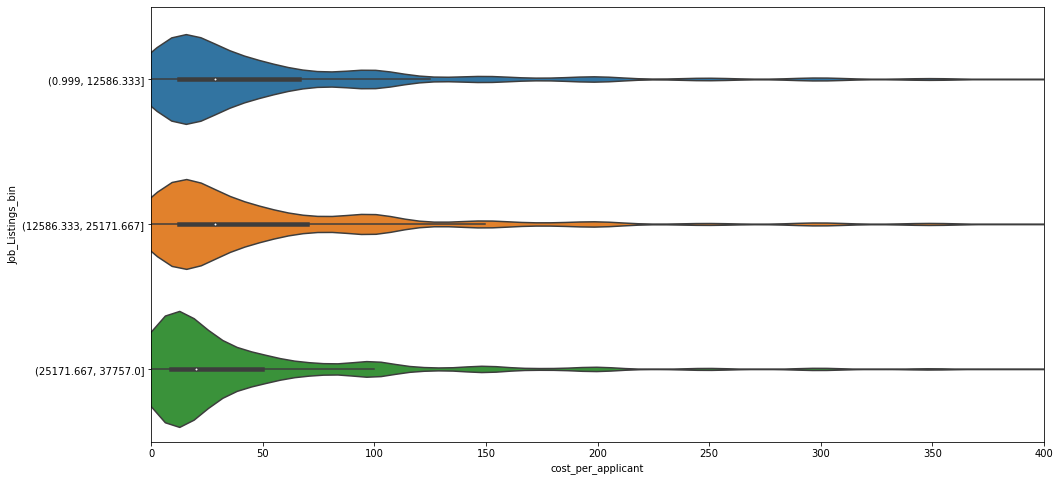

In [73]:
metrics = ['cost_per_applicant']
df_metrics['Job_Listings_bin'] = pd.qcut(df_metrics['Job_Listings'].rank(method='first'), q=3)
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
for idx, metric in enumerate(metrics):
    ax = plt.subplot(1, 1, idx + 1) 
    sns.violinplot(y='Job_Listings_bin', x=metric, data=df_metrics.replace([np.inf, -np.inf], np.nan).dropna())
    plt.xlim(0, 10)
    if metric == 'apply_conv_rate':
        plt.xlim(0, 1.25)
    elif metric == 'cost_per_applicant':
        plt.xlim(0, 400)